# GMM 再测试

In [12]:
# 确保src目录在Python路径中
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../"))

# 导入模块
from src.data_utils import (
    extract_seismic_attributes_for_wells,
    extract_uniform_seismic_samples,
    filter_anomalous_attributes,
    filter_outlier_wells,
    filter_seismic_by_wells,
    identify_attributes,
    parse_petrel_file,
    preprocess_features,
)
from src.feature_selection import select_best_features
from src.gmm_clustering import evaluate_gmm_clusters, perform_gmm_clustering
from src.pca_analysis import perform_pca_analysis
from src.visualization import visualize_attribute_map, visualize_gmm_clustering, visualize_pca_clustering

data_dir = "..\\data"
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# 设置中文字体
plt.rcParams["font.family"] = "SimHei"  # 黑体 SimHei 支持中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

## 导入地震数据


In [13]:
data_seismic_attr = parse_petrel_file(os.path.join(data_dir, "H6-2_attr"))

正在解析文件: ..\data\H6-2_attr
正在识别文件属性: ..\data\H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
识别到的列含义: ['X', 'Y', 'Z', 'column', 'row']
数据行有 20 列，列名列表有 20 个


c:\Users\WangQinZhuo\Program\attribute_fusion_0526\src\data_utils.py:111: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


成功读取数据，共 51714 行

数据预览:
               X             Y            Z  column  row  Average energy  \
0  688546.288809  3.211900e+06 -2472.896240   128.0  1.0      3538352.25   
1  688596.288809  3.211900e+06 -2475.649902   129.0  1.0      6365790.00   
2  688446.288809  3.211950e+06 -2465.910889   126.0  2.0      9748781.00   
3  688496.288809  3.211950e+06 -2469.487061   127.0  2.0      5062806.00   
4  688546.288809  3.211950e+06 -2472.695801   128.0  2.0      2440221.75   

   Average envelope  Average instantaneous frequency  \
0       3114.544678                        32.982338   
1       3344.748779                        33.155682   
2       4269.621094                        35.096291   
3       3648.766113                        31.971563   
4       2865.032471                        31.293999   

   Average instantaneous phase  Average peak value  Geometric mean  \
0                   -75.810104              -999.0          -999.0   
1                   -86.797714            

## 导入井点位置


In [14]:
data_well_position = pd.read_excel(os.path.join(data_dir, "well_without_attr.xlsx"))

# 选择对应层位的行，丢弃砂厚为 NaN 的行
data_well_purpose_surface_position = (
    data_well_position[data_well_position["Surface"] == "H6-2"]
    .replace(-999, np.nan)  # 将-999替换为NaN
    .dropna(subset=["Sand Thickness"])  # 丢弃砂厚为NaN的行
    .reset_index(drop=True)  # 重置索引
)
data_well_purpose_surface_position.head()

,X,Y,Z,Surface,Well,Sand Thickness,Sand Ratio
0,686325.6,3217019.1,-2649.7,H6-2,A1,0.00,0.00
1,686616.5,3217415.2,-2633.0,H6-2,A10,7.87,45.82
2,686278.0,3217627.9,-2650.4,H6-2,A11,0.00,0.00
3,686149.5,3216665.5,-2642.5,H6-2,A2,0.75,5.16
4,685921.1,3216986.2,-2644.7,H6-2,A4,0.00,0.00


## 筛除离群井


筛选前井点数量: 30
筛选后井点数量: 26


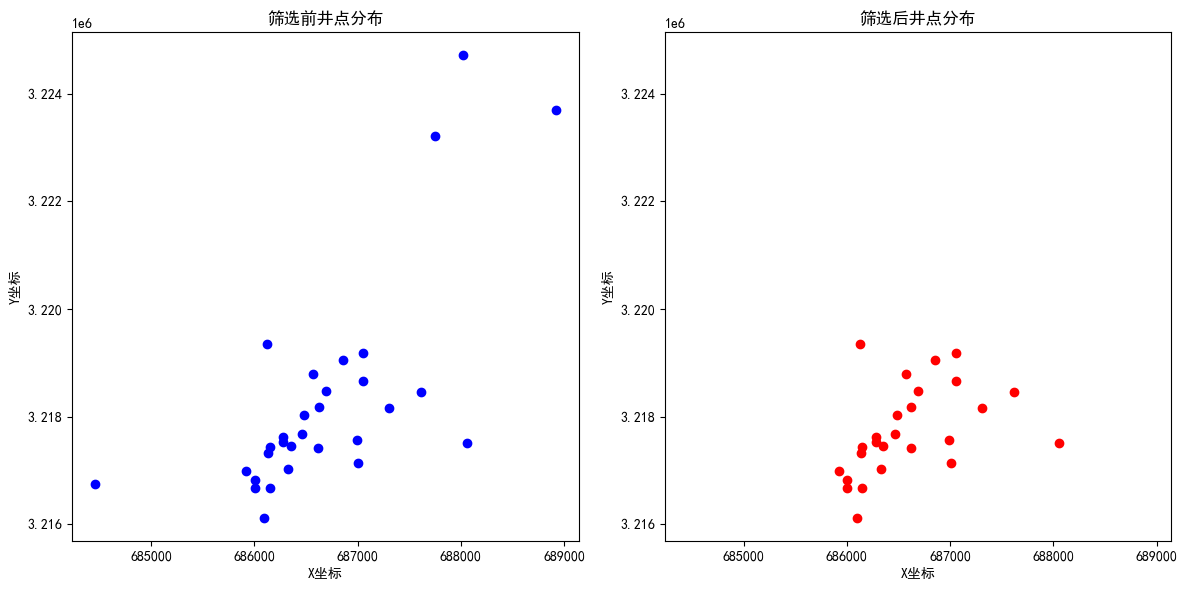

In [15]:
# 筛选离群井
data_well_purpose_surface_filtered = filter_outlier_wells(data_well_purpose_surface_position, method="iqr")

# 显示筛选前后的井点数量
print(f"筛选前井点数量: {len(data_well_purpose_surface_position)}")
print(f"筛选后井点数量: {len(data_well_purpose_surface_filtered)}")

# 可视化筛选前后的井点分布
plt.figure(figsize=(12, 6))

# 计算坐标范围（使用所有井点的数据来确定范围）
x_min = data_well_purpose_surface_position["X"].min()
x_max = data_well_purpose_surface_position["X"].max()
y_min = data_well_purpose_surface_position["Y"].min()
y_max = data_well_purpose_surface_position["Y"].max()

# 可选：添加一些边距使图更美观
margin = 0.05  # 5%的边距
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * margin
x_max += x_range * margin
y_min -= y_range * margin
y_max += y_range * margin

# 绘制筛选前的井点分布
plt.subplot(1, 2, 1)
plt.scatter(data_well_purpose_surface_position["X"], data_well_purpose_surface_position["Y"], c="blue")
plt.title("筛选前井点分布")
plt.xlabel("X坐标")
plt.ylabel("Y坐标")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# 绘制筛选后的井点分布
plt.subplot(1, 2, 2)
plt.scatter(data_well_purpose_surface_filtered["X"], data_well_purpose_surface_filtered["Y"], c="red")
plt.title("筛选后井点分布")
plt.xlabel("X坐标")
plt.ylabel("Y坐标")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "well_filtering_comparison.png"))
plt.show()

## 处理属性缺失值


In [16]:
# 首先获取地震属性列表
attribute_names, _ = identify_attributes(os.path.join(data_dir, "H6-2_attr"))

# 使用preprocess_features处理地震数据
processed_seismic, attr_stats = preprocess_features(
    data=data_seismic_attr,
    attribute_columns=attribute_names,
    missing_values=[-999],
    missing_threshold=0.6,  # 缺失值超过60%的列将被删除
    outlier_method="iqr",
    outlier_threshold=1.5,
    verbose=True,
)

# 提取筛选后的属性
attribute_names_filtered = [col for col in processed_seismic.columns]

# 将处理后的属性数据与原始坐标数据合并
processed_seismic_full = data_seismic_attr[["X", "Y"]].copy()
for col in processed_seismic.columns:
    processed_seismic_full[col] = processed_seismic[col]

正在识别文件属性: ..\data\H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
处理前特征: (51714, 15)

每列缺失值情况:
  - Average energy: 0 (0.00%)
  - Average envelope: 0 (0.00%)
  - Average instantaneous frequency: 0 (0.00%)
  - Average instantaneous phase: 0 (0.00%)
  - Average peak value: 36625 (70.82%)
  - Geometric mean: 44667 (86.37%)
  - Half energy: 0 (0.00%)
  - Harmonic mean: 0 (0.00%)
  - Maximum amplitude: 225 (0.44%)
  - Mean amplitude: 0 (0.00%)
  - Minimum amplitude: 197 (0.38%)
  - Most of: 0 (0.00%)
  - RMS amplitude: 0 (0.00%)
  - Sum of amplitudes: 0 (0.00%)
  - Sum of energy: 0 (0.00%)

删除以下缺失值比例 >= 60.0% 的列: ['Average peak value', 'Geometric mean']
  - 属性 'Average energy'的填

## 根据井点分布，缩小工区范围


井点数据X轴范围: 685921.10 到 688057.00
井点数据Y轴范围: 3216119.60 到 3219350.50
原始地震数据点数: 51714
缩小范围后的地震数据点数: 6208
数据量减少了: 88.00%


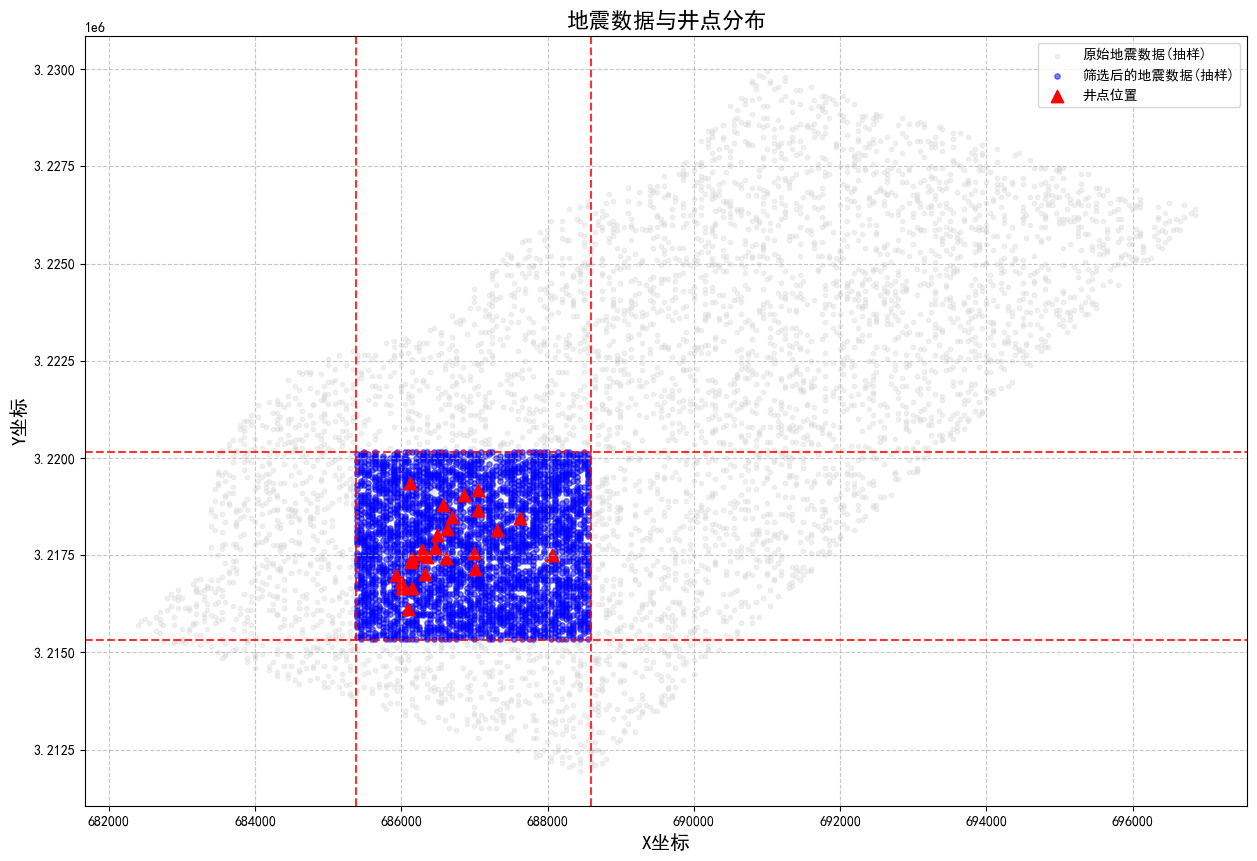

区域边界信息:
  x_min: 685387.125
  x_max: 688590.975
  y_min: 3215311.875
  y_max: 3220158.225
  x_center: 686989.05
  y_center: 3217735.05
  expansion_factor: 1.5


In [17]:
# 限制工区范围
seismic_attr_filtered, area_bounds = filter_seismic_by_wells(
    seismic_data=processed_seismic_full,
    well_data=data_well_purpose_surface_filtered,
    expansion_factor=1.5,  # 扩展50%
    plot=True,
    output_dir=output_dir,
)

# 后续可以直接使用area_bounds中的边界信息
print("区域边界信息:")
for key, value in area_bounds.items():
    print(f"  {key}: {value}")

## 提取井点处地震属性


In [18]:
# 为筛选前的井点提取地震属性
well_attr = extract_seismic_attributes_for_wells(
    well_data=data_well_purpose_surface_position,
    seismic_data=processed_seismic_full,
    max_distance=50,
    num_points=5,
)

# 为筛选后的井点提取地震属性
well_attr_filtered = extract_seismic_attributes_for_wells(
    well_data=data_well_purpose_surface_filtered, seismic_data=processed_seismic_full, max_distance=50, num_points=5
)

# 保存处理结果
well_attr.to_excel(os.path.join(data_dir, "wells_attr.xlsx"), index=False)
print("筛选前井点的地震属性已保存到 wells_attr.xlsx")
well_attr_filtered.to_excel(os.path.join(data_dir, "wells_attr_filtered.xlsx"), index=False)
print("筛选后井点的地震属性已保存到 wells_attr_filtered.xlsx")

筛选前井点的地震属性已保存到 wells_attr.xlsx
筛选后井点的地震属性已保存到 wells_attr_filtered.xlsx


## 生成统计摘要


In [19]:
# 筛选出质量良好的属性
good_attributes, anomalous_attributes, attribute_stats = filter_anomalous_attributes(
    seismic_data=seismic_attr_filtered,
    well_data=well_attr_filtered,
    common_attributes=attribute_names_filtered,
    ratio_threshold=5.0,  # 均值比值阈值
    range_ratio_threshold=10.0,  # 数值范围比值阈值
    std_ratio_threshold=10.0,  # 标准差比值阈值
    output_dir=None,  # 输出图表目录
    verbose=True,  # 打印详细信息
)

print("\n筛选后保留的质量良好属性:")
for attr in good_attributes:
    print(f"- {attr}")

======== 井点数据与地震数据的属性统计比较 ========

共分析了 13 个共同属性
发现 2 个异常属性
保留 11 个质量良好的属性

异常属性及原因:
  - Harmonic mean: 标准差比值异常 (272.2503), 数值范围比值异常 (5819.9082)
  - Mean amplitude: 均值比值为负 (-1.2599)

筛选后保留的质量良好属性:
- Average instantaneous phase
- Sum of amplitudes
- Sum of energy
- Minimum amplitude
- Most of
- Maximum amplitude
- Average energy
- Average envelope
- Average instantaneous frequency
- Half energy
- RMS amplitude


## PCA 降维

======== PCA降维分析开始 ========
数据集大小: (6208, 15)
为保留至少75.0%的方差，需要保留3个主成分


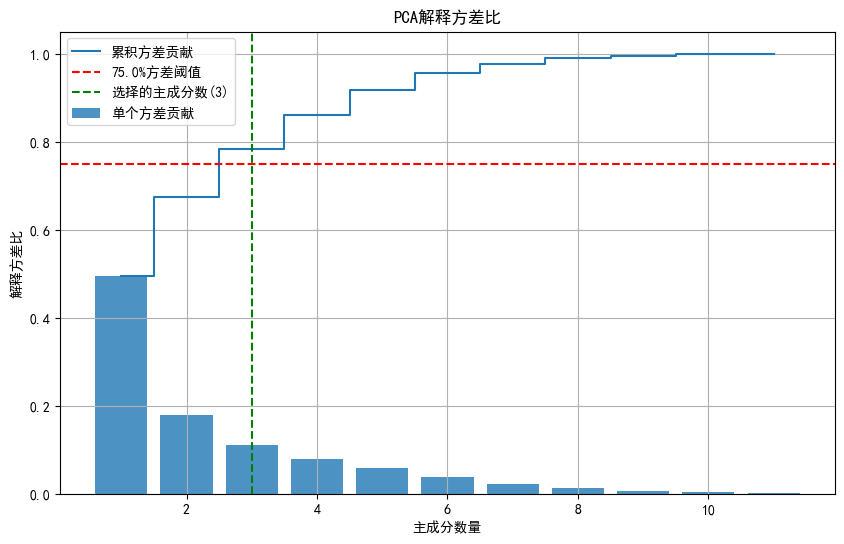

降维后的特征形状: (6208, 3)

主成分与原始特征的关系:
     Average instantaneous phase  Sum of amplitudes  Sum of energy  \
PC1                    -0.236938          -0.097643       0.402586   
PC2                     0.028575           0.608361       0.065812   
PC3                    -0.293405          -0.225114      -0.033347   

     Minimum amplitude   Most of  Maximum amplitude  Average energy  \
PC1          -0.369819 -0.342729           0.232333        0.391109   
PC2           0.188044  0.262416           0.526579        0.051786   
PC3          -0.190209 -0.260105          -0.045540       -0.199828   

     Average envelope  Average instantaneous frequency  Half energy  \
PC1          0.388660                         0.008529     0.020630   
PC2          0.078421                         0.220454     0.429339   
PC3         -0.241524                         0.704555     0.363550   

     RMS amplitude  
PC1       0.399402  
PC2       0.038421  
PC3      -0.171422  
======== PCA降维分析完成 ========


In [20]:
pca_results = perform_pca_analysis(
    data=seismic_attr_filtered,
    attribute_columns=good_attributes,
    variance_threshold=0.75,
    output_dir=output_dir,
)

## GMM 聚类

======== GMM聚类数评估开始 ========
聚类数量 1: BIC = 68796.39, AIC = 68735.78
聚类数量 2: BIC = 63844.07, AIC = 63716.13
聚类数量 3: BIC = 62006.91, AIC = 61811.64
聚类数量 4: BIC = 60834.88, AIC = 60572.27
聚类数量 5: BIC = 59952.24, AIC = 59622.29
聚类数量 6: BIC = 59542.90, AIC = 59145.62
聚类数量 7: BIC = 59416.20, AIC = 58951.58
聚类数量 8: BIC = 59098.20, AIC = 58566.24
聚类数量 9: BIC = 59031.10, AIC = 58431.81
聚类数量 10: BIC = 59022.42, AIC = 58355.79


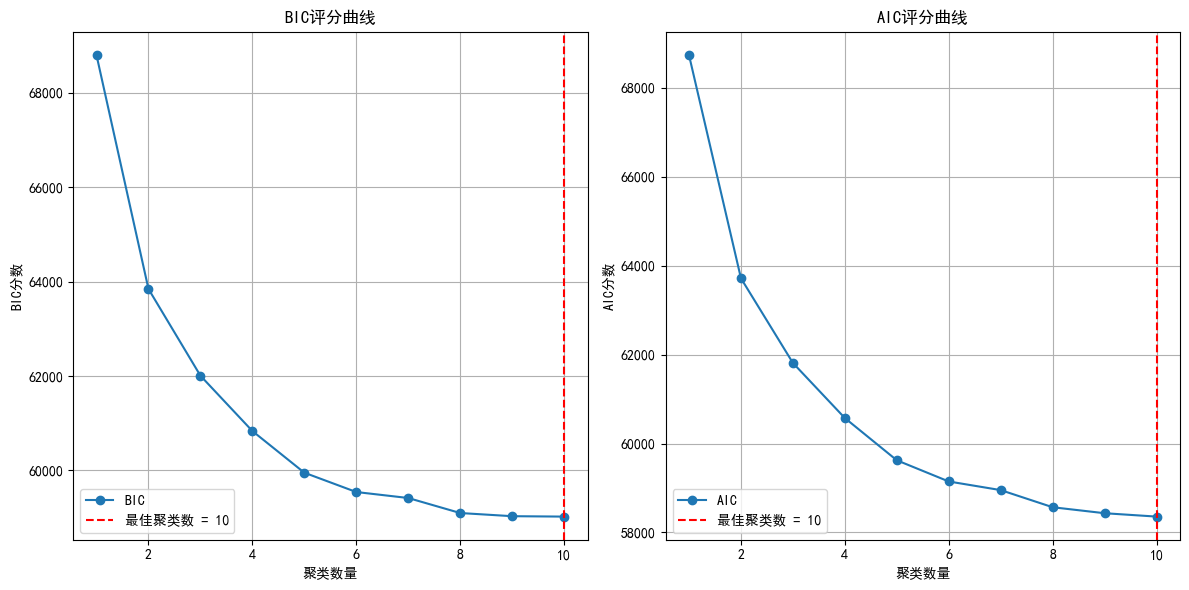

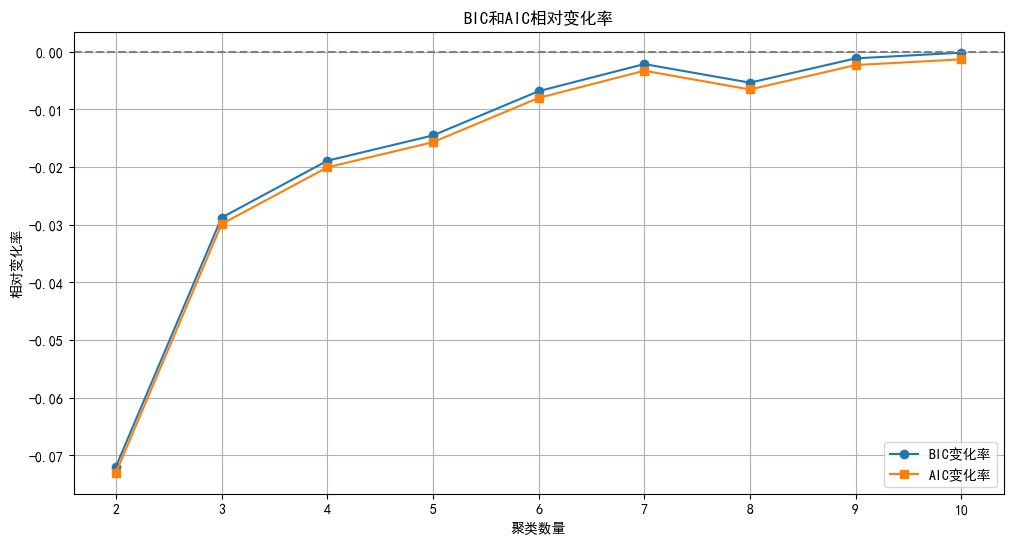

BIC变化率最大变化点: 聚类数 = 2
AIC变化率最大变化点: 聚类数 = 2

基于BIC的最佳聚类数: 10
基于AIC的最佳聚类数: 10
======== GMM聚类数评估完成 ========


In [21]:
# 首先评估最佳聚类数
gmm_evaluation = evaluate_gmm_clusters(features_pca=pca_results["features_pca"], max_clusters=10, output_dir=output_dir)

# 使用不同的聚类数执行GMM聚类
# 根据BIC/AIC结果选择的最佳聚类数
# best_n = gmm_evaluation["best_n_components"]

======== 执行 3 聚类的GMM分析 ========

各聚类样本数量:
聚类 0: 1958 样本 (31.54%)
聚类 1: 1623 样本 (26.14%)
聚类 2: 2627 样本 (42.32%)
======== 3 聚类的GMM分析完成 ========


c:\Users\WangQinZhuo\miniconda3\envs\env-af\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


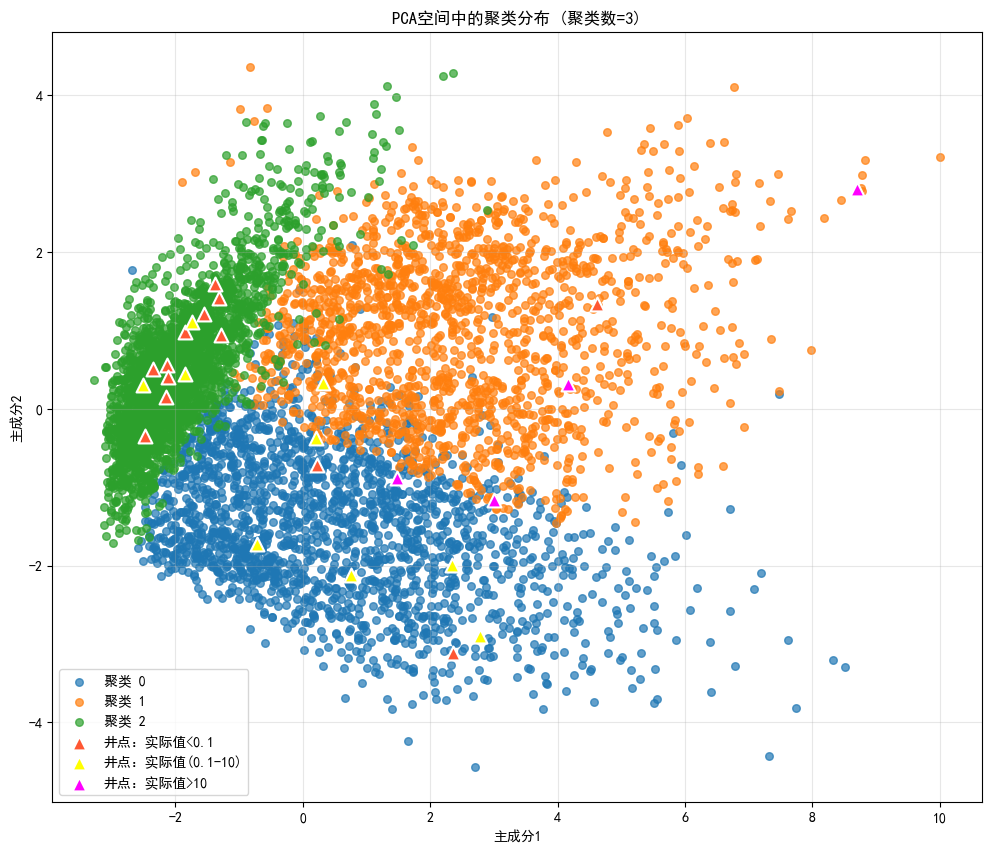

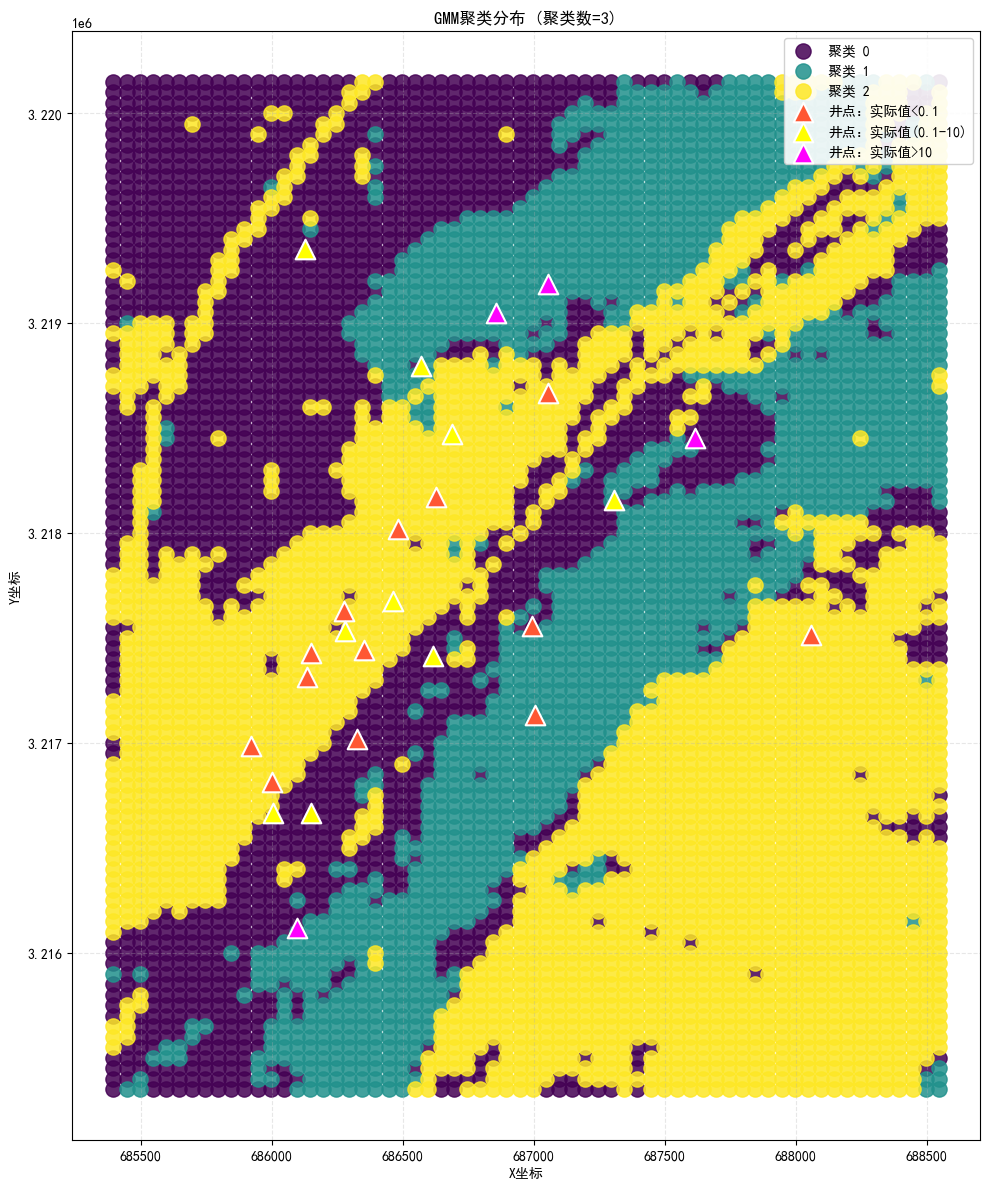

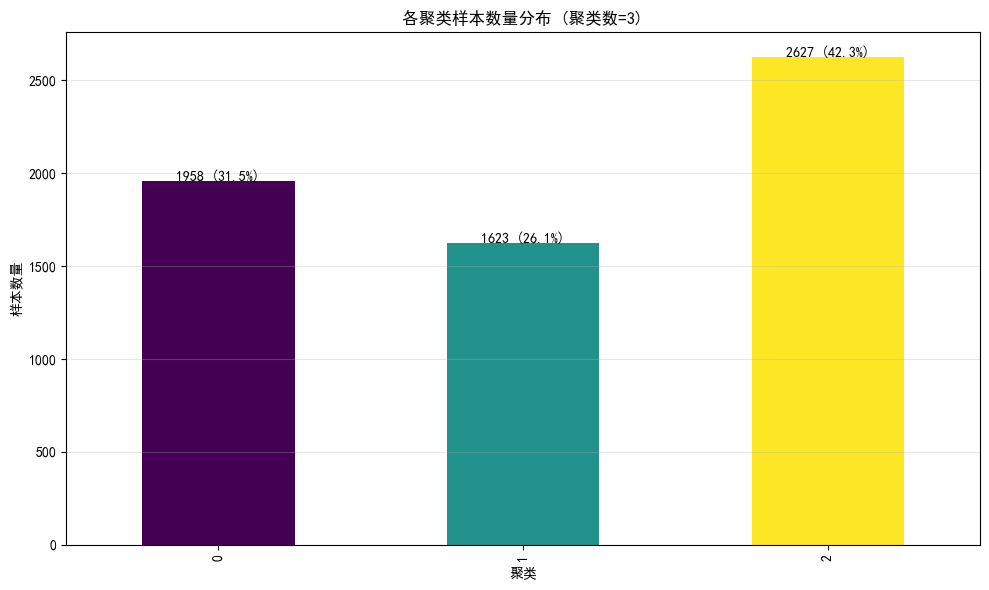

In [22]:
best_n = 3  # 聚类数量

# 1. 执行GMM聚类
gmm_results = perform_gmm_clustering(
    features=pca_results["features_pca"],
    coords=pca_results["coords_clean"],
    n_clusters=best_n,
)
gmm_results["result_df"].to_csv(os.path.join(output_dir, "gmm_best_clusters.csv"), index=False)

# 2. PCA可视化，需要将井点数据投影到PCA空间
# 首先提取井点的属性列
well_features = well_attr_filtered[pca_results["features_clean"].columns].values
# 使用相同的标准化器和PCA模型变换井点数据
well_features_scaled = pca_results["scaler"].transform(well_features)
well_pca_features = pca_results["pca"].transform(well_features_scaled)

# 3. 在PCA空间中可视化聚类结果
visualize_pca_clustering(
    clustering_results=gmm_results,
    pca_results=pca_results,
    n_clusters=best_n,
    output_dir=output_dir,
    prefix="pca",
    well_data=data_well_purpose_surface_filtered,
    well_pca_features=well_pca_features,
    target_column="Sand Thickness",
    class_thresholds=[0.1, 10],
)

# 4. 在地理空间中可视化聚类结果
visualize_gmm_clustering(
    clustering_results=gmm_results,
    output_dir=output_dir,
    prefix="pca",
    well_data=data_well_purpose_surface_filtered,
    target_column="Sand Thickness",
    class_thresholds=[0.1, 10],
    point_size=120,
    well_size=200,
)